In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
import flopy
import flopy.plot.styles as styles
from dis2disu import Dis2Disu

In [2]:
ws = './disu_model'

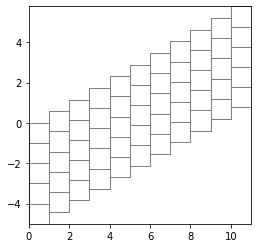

In [3]:
# Lx is the full width of the model domain. The grid spacing in
# the x direction is delr = Lx / ncol, and so the horizontal distance
# between the left and right boundary conditions is Lx - delr. The
# cells are square, i.e., delz = delr. The cross-sectional model has
# unit thickness "into the page," i.e., nrow = 1 and delc = 1.

# The full thickness of the channel measured vertically is nlay * delz.
# Theta is the angle (deg) at which the channel slopes, and so the
# width of the "true" channel measured perpendicularly to the slope,
# i.e., the width avaiable for flow along the slope of the channel,
# is nlay * delz * cos(theta). The increase in elevation as one moves
# a column to the right is delr * tan(theta).

# adjustable grid parameters
nlay, ncol = 5, 11
Lx = 11.0
theta = 30.
#theta = math.atan(0.5) * 180. / math.pi   # this theta gives exactly 1/2 cell overlap

# grid parameters intended to remain fixed
nrow = 1
delc = 1.

# computed grid parameters
delr = float(Lx / ncol)
delz = delr
zoffset = delr * math.tan(theta * math.pi / 180.)
top = np.linspace(0., (ncol - 1) * zoffset, ncol)
top = top.reshape((nrow, ncol))
botm = np.empty((nlay, nrow, ncol))
botm[0] = top - delz
for k in range(1, nlay):
    botm[k] = botm[k - 1] - delz

# plot dis grid
delr = delr * np.ones(ncol, dtype=float)
delc = delc * np.ones(nrow, dtype=float)
mgs = flopy.discretization.StructuredGrid(delr=delr, delc=delc,
                                          top=top, botm=botm)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect="equal")
xs = flopy.plot.PlotCrossSection(modelgrid=mgs, ax=ax, line={"row":0})
xs.plot_grid()

In [4]:
# scenario parameters
parameters = {
    "disu-s-nocc": {
        "xt3d": False,
        "staggered": False,
        "crossflow": False,
    },
    "disu-x-nocc": {
        "xt3d": True,
        "staggered": False,
        "crossflow": False,
    },
    "disu-s-cc": {
        "xt3d": False,
        "staggered": True,
        "crossflow": False,
    },
    "disu-x-cc": {
        "xt3d": True,
        "staggered": True,
        "crossflow": False,
    },
    "disu-s-nocc-cf": {
        "xt3d": False,
        "staggered": False,
        "crossflow": True,
    },
    "disu-x-nocc-cf": {
        "xt3d": True,
        "staggered": False,
        "crossflow": True,
    },
    "disu-s-cc-cf": {
        "xt3d": False,
        "staggered": True,
        "crossflow": True,
    },
    "disu-x-cc-cf": {
        "xt3d": True,
        "staggered": True,
        "crossflow": True,
    },
}

In [5]:
def calculate_head_analyt(crossflow):
    global head_analyt

    # Analytical head a la Bardot et al (2022),
    # assuming a head gradient of magnitude -1.:
    # head = - cos(theta) * x - sin(theta) * z

    thetarad = theta * math.pi / 180.
    sintheta = math.sin(thetarad)
    costheta = math.cos(thetarad)
    if crossflow:
        hgradx = sintheta
        hgradz = -costheta
    else:
        hgradx = -costheta
        hgradz = -sintheta

    head_analyt = []

    for klay in range(nlay):
        zdrop = float(klay + 0.5) * delz
        for jcol in range(ncol):
            xc = float(jcol + 0.5) * delr[0]
            zc = top[0][jcol] - zdrop
            hc = hgradx * xc + hgradz * zc
            head_analyt.append(hc)

    return

In [6]:
def print_spdis_summary(qx, qy, qz, crossflow):
    from tabulate import tabulate

    jcolmid = int(ncol / 2)
    klaymid = int(nlay / 2)
    
    qmagmin = qangmin = qmagmid = float('inf')
    qmagmax = qangmax = qangmid = float('-inf')
    qmagavg = qangavg = 0.
    ncount = 0
    icell = -1
    for klay in range(nlay):
        for jcol in range(ncol):
            icell += 1
            qqx = qx[icell]
            qqz = qz[icell]
            qmag = math.sqrt(qqx * qqx + qqz * qqz)
            if (qqx == 0.):
                if (qqz == 0.):
                    qang = 0.
                elif (qqz > 0.):
                    qang = 90.
                else:
                    qang = -90.
            else:
                #qang = math.atan(qqz / qqx) * 180. / math.pi
                qang = math.atan2(qqz, qqx) * 180. / math.pi
            ncount += 1
            qmagmin = min([qmagmin, qmag])
            qmagmax = max([qmagmax, qmag])
            qmagavg += qmag
            qangmin = min([qangmin, qang])
            qangmax = max([qangmax, qang])
            qangavg += qang
            if (klay == klaymid) and (jcol == jcolmid):
                qmagmid = qmag
                qangmid = qang
    qmagavg = qmagavg / ncount
    qangavg = qangavg / ncount
    qmagana = 1.
    #slope = (top[0][1] - top[0][0]) / delr[0]
    #qangana = math.atan(slope) * 180. / math.pi
    qangana = math.atan2(top[0][1] - top[0][0], delr[0]) * 180. / math.pi
    if crossflow:
        qangana += 90.

    print ("\nSPECIFIC DISCHARGE:")
    qdata = [
        ["analytical", qmagana, qangana],
        ["mid-channel", qmagmid, qangmid],
        ["avg", qmagavg, qangavg],
        ["min", qmagmin, qangmin],
        ["max", qmagmax, qangmax],
    ]
    qhead = ["", "magnitude", "angle",]
    print(tabulate(qdata, headers=qhead, tablefmt="simple", floatfmt=".14f"))
    
    return

In [7]:
def build_model(sim_name, xt3d, staggered, crossflow):
    global d2d
    
    # convert to disu grid
    d2d = Dis2Disu(delr, delc, top, botm, staggered=staggered)
    
    sim_ws = os.path.join(ws, sim_name)
    sim = flopy.mf6.MFSimulation(sim_name=sim_name, sim_ws=sim_ws, exe_name='./bin/mf6')
    tdis = flopy.mf6.ModflowTdis(sim)
    ims = flopy.mf6.ModflowIms(sim, linear_acceleration='bicgstab')
    gwf = flopy.mf6.ModflowGwf(sim, modelname=sim_name,
                               save_flows=True, print_flows=True)
    disu = flopy.mf6.ModflowGwfdisu(gwf, **d2d.get_gridprops_disu6())
    ic = flopy.mf6.ModflowGwfic(gwf)
    npf = flopy.mf6.ModflowGwfnpf(gwf, save_specific_discharge=True,
                                  xt3doptions=xt3d,
                                  angle1=0., angle2=0., angle3=0.)

    # Set boundary heads to analytical values
    calculate_head_analyt(crossflow)
    spd = []
    for klay in range(nlay):
        icleft = klay*ncol
        icright = icleft + ncol - 1
        spd.append([(icleft,), head_analyt[icleft]])
        spd.append([(icright,), head_analyt[icright]])
    if crossflow:
        for jcol in range(1, ncol - 1):
            ictoplay = jcol
            icbotlay = ictoplay + (nlay - 1) * ncol
            spd.append([(ictoplay,), head_analyt[ictoplay]])
            spd.append([(icbotlay,), head_analyt[icbotlay]])
    chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data=spd)

    budget_file = sim_name + '.bud'
    head_file = sim_name + '.hds'
    oc = flopy.mf6.ModflowGwfoc(gwf,
                                budget_filerecord=budget_file,
                                head_filerecord=head_file,
                                saverecord=[('HEAD', 'ALL'), ('BUDGET', 'ALL')],
                                printrecord=[('BUDGET', 'ALL'), ('HEAD', 'ALL')],)

    return sim

In [8]:
def simulation(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_model(key, **params)
    sim.write_simulation(silent=silent)
    success, buff = sim.run_simulation(silent=silent, report=True)
    if not success:
        print(buff)
    else:
        plot_results(idx, sim)

In [9]:
def plot_results(idx, sim):

    sim_name = list(parameters.keys())[idx]
    sim_ws = os.path.join(ws, sim_name)
    gwf = sim.get_model(sim_name)
    staggered = parameters[sim_name]["staggered"]
    crossflow = parameters[sim_name]["crossflow"]

    head = gwf.output.head().get_data()
    bud = gwf.output.budget()
    spdis = bud.get_data(text='DATA-SPDIS')[0]
    qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)
    # if cross-connections, recalculate qx taking into account overlap areas
    if staggered:
        flowja = bud.get_data(text='FLOW-JA')[0][0][0]
        gp = d2d.get_gridprops_disu6()
        iac = gp["iac"]
        ja = gp["ja"]
        ihc = gp["ihc"]
        topbycell = gp["top"]
        botbycell = gp["bot"]
        hwva = gp["hwva"]
        iconn = -1
        icell = -1
        for il in iac:
            icell += 1
            qxnumer = 0.
            qxdenom = 0.
            for ilnbr in range(il):
                iconn += 1
                if ihc[iconn] == 2:
                    inbr = ja[iconn]
                    if (inbr == icell):
                        continue
                    dz = min(topbycell[icell], topbycell[inbr]) - max(botbycell[icell], botbycell[inbr])
                    qxincr = flowja[iconn] / (hwva[iconn] * dz)
                    # equal weight given to each face, but could weight by distance instead
                    if (inbr < icell):
                        qxnumer += qxincr
                    else:
                        qxnumer -= qxincr
                    qxdenom += 1.
            qx[icell] = qxnumer / qxdenom

    # print specific discharge summary
    print_spdis_summary(qx, qy, qz, crossflow)

    # plot head and specific discharge and save figure
    fig = plt.figure(figsize=(6, 6))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    xs = flopy.plot.PlotCrossSection(model=gwf, ax=ax,
                                     line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    xs.plot_grid()
    cb = xs.plot_array(head, cmap="jet")
    cbar = plt.colorbar(cb, shrink=0.25)
    cbar.ax.set_xlabel(r"Head, ($m$)")
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")
    xs.plot_vector(qx, qy, qz, scale=10, normalize=False, color="black",
                   width=0.0075, headwidth=3, headlength=5, headaxislength=4)
    figure_ext = ".png"
    fpth0 = os.path.join(
        "..", "figures", "{}-head{}".format(sim_name, figure_ext)
    )
    plt.close(fig)
    fig.savefig(fpth0)

    # plot head error and save figure
    fig = plt.figure(figsize=(6, 6))
    fig.tight_layout()
    ax = fig.add_subplot(1, 1, 1, aspect="equal")
    xs = flopy.plot.PlotCrossSection(model=gwf, ax=ax,
                                     line={"line": [(0.0, 0.5), (Lx, 0.5)]})
    xs.plot_grid()
    cb = xs.plot_array(head - np.array(head_analyt), cmap="jet")
    cbar = plt.colorbar(cb, shrink=0.25)
    cbar.ax.set_xlabel(r"Error, ($m$)")
    ax.set_xlabel("x position (m)")
    ax.set_ylabel("y position (m)")
    figure_ext = ".png"
    fpth1 = os.path.join(
        "..", "figures", "{}-error{}".format(sim_name, figure_ext)
    )
    plt.close(fig)
    fig.savefig(fpth1)

    # display the two saved figures inline in a combined figure
    fig, ax = plt.subplots(1, 2, figsize=(16, 10))
    ax[0].set_axis_off()
    ax[0].imshow(plt.imread(fpth0))
    ax[1].set_axis_off()
    ax[1].imshow(plt.imread(fpth1))
    plt.show()
    
    return

Simulation results for scenario 0, which features:
1. no cross-connections (not staggered)
2. standard conductance formulation (xt3d off)
3. flow along the channel


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.15603855365205   2.75709168858864
avg          1.18265667110805   9.55267346285013
min          0.83185451939218   1.71639779867762
max          1.69971069508116  36.13084170175075


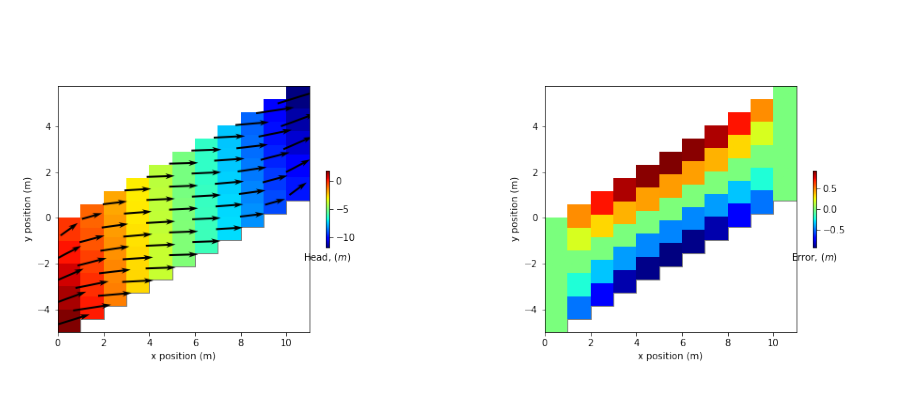

In [10]:
simulation(0)

Simulation results for scenario 1, which features:
1. no cross-connections (not staggered)
2. xt3d
3. flow along the channel


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.05467809571797   2.96272054865442
avg          1.09262195588113  10.37710505493821
min          0.75465744860949   1.89192820840117
max          1.62049306428647  39.67033530921852


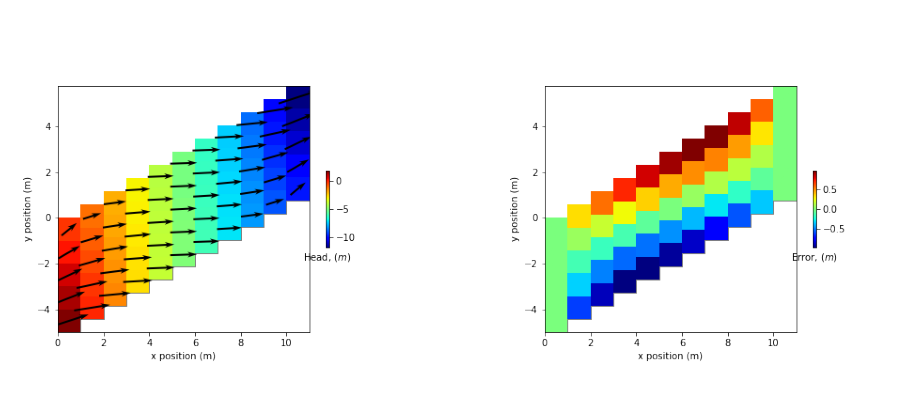

In [11]:
simulation(1)

Simulation results for scenario 2, which features:
1. cross-connections (staggered)
2. standard conductance formulation (xt3d off)
3. flow along the channel


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  1.02446304932743  24.24669986661220
avg          1.06698653700283  24.64402785458299
min          0.98950395814795  21.68905380686553
max          1.35292644135397  30.35151396738050


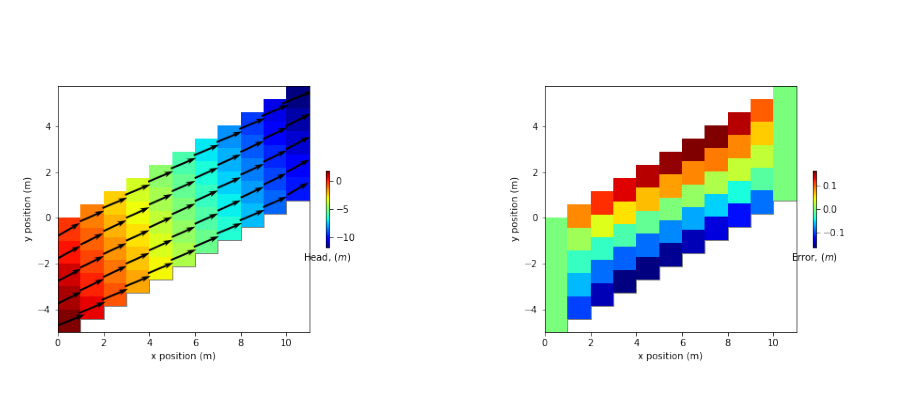

In [12]:
simulation (2)

Simulation results for scenario 3, which features:
1. cross-connections (staggered)
2. xt3d
3. flow along the channel


SPECIFIC DISCHARGE:
                    magnitude              angle
-----------  ----------------  -----------------
analytical   1.00000000000000  30.00000000000000
mid-channel  0.99999999998974  30.00000003784743
avg          1.00000000067130  29.99999999675569
min          0.99999999787262  29.99999961538031
max          1.00000000603185  30.00000007224524


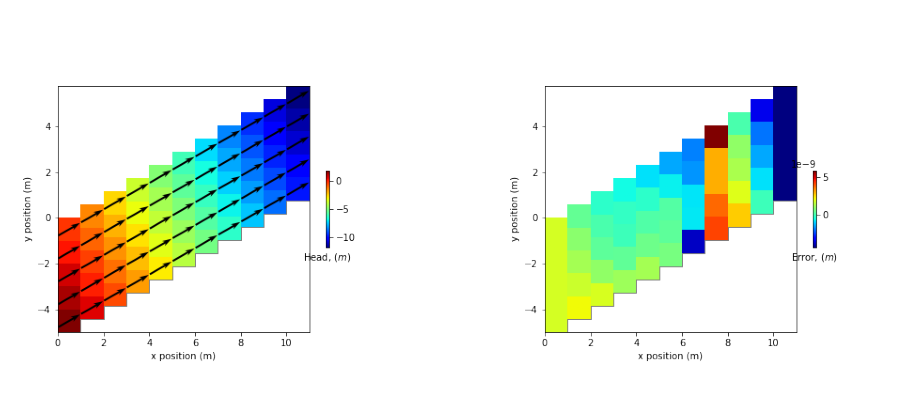

In [13]:
simulation(3)

Simulation results for scenario 0, which features:
1. no cross-connections (not staggered)
2. standard conductance formulation (xt3d off)
3. flow across the channel


SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  0.86602540538285   90.00000015725618
avg          0.86602540531105   89.99999999444363
min          0.86602538841980   89.99999945057725
max          0.86602542285289   90.00000051018158


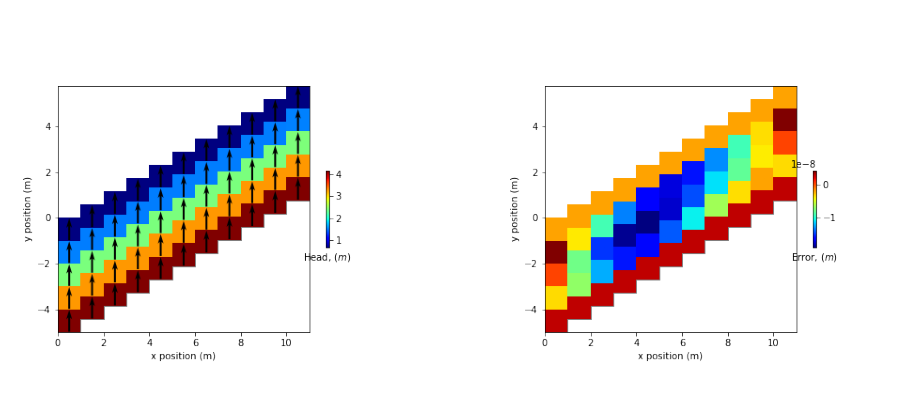

In [14]:
simulation(4)

Simulation results for scenario 1, which features:
1. no cross-connections (not staggered)
2. xt3d
3. flow across the channel


SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  1.00000000108470  119.99999996990879
avg          1.00000000160003  119.99999998346441
min          0.99999999550138  119.99999965723093
max          1.00000000703286  120.00000021696265


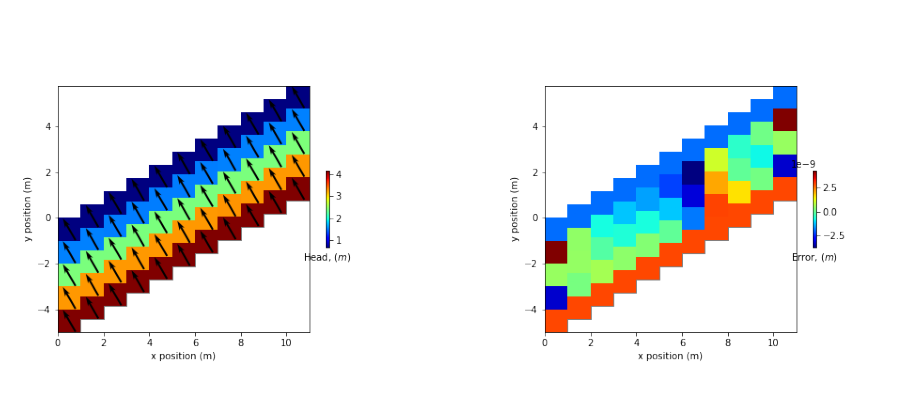

In [15]:
simulation(5)

Simulation results for scenario 2, which features:
1. cross-connections (staggered)
2. standard conductance formulation (xt3d off)
3. flow across the channel


SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  0.96824583773106  116.56505112648173
avg          0.94640603452451  112.93828854211256
min          0.86602541000000   90.00000000000000
max          0.96824584291275  116.56505148612160


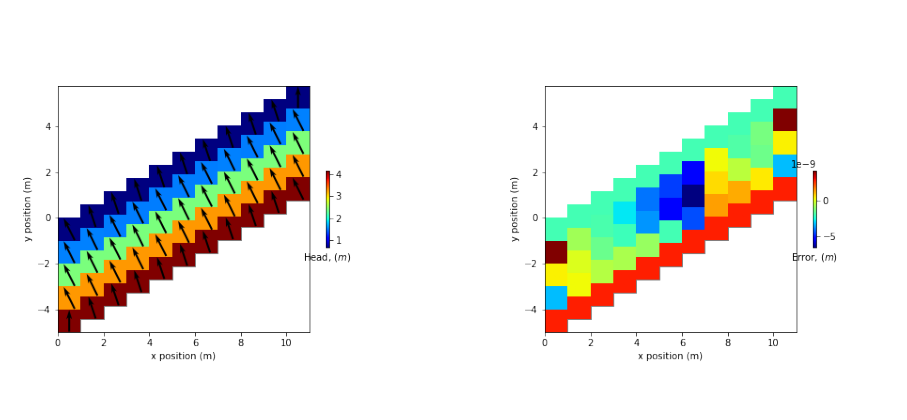

In [16]:
simulation (6)

Simulation results for scenario 3, which features:
1. cross-connections (staggered)
2. xt3d
3. flow across the channel


SPECIFIC DISCHARGE:
                    magnitude               angle
-----------  ----------------  ------------------
analytical   1.00000000000000  120.00000000000000
mid-channel  1.00000000088588  119.99999995662135
avg          1.00000000167100  119.99999999621505
min          0.99999999695719  119.99999984201767
max          1.00000000701833  120.00000022705763


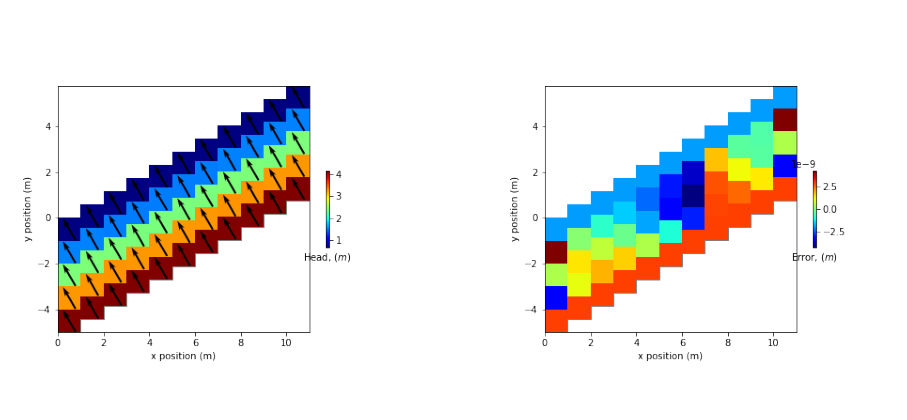

In [17]:
simulation(7)